In [1]:
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import sys
sys.path.insert(0,'..')
import module as mod

from keras.layers import Dropout, Layer, Dense, Input, Lambda
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import backend as K

#from kerashypetune import KerasGridSearch

This notebook is an adaptation of the following Git repository : https://github.com/cerlymarco/MEDIUM_NoteBook/tree/master/Time2Vec

# 0. Load and prepare our dataset
First we'll load our datasets

In [2]:
### READ DATA ###

house1_power_blk2 = mod.load_dataset('house1_power_blk2_labels.zip').resample('1min').mean()
house1_power_blk2['activity'] = (house1_power_blk2['activity'] > 0.5).astype(int)
house2_power_blk1 = mod.load_dataset('house2_power_blk1_labels.zip').resample('1min').mean()
house2_power_blk1['activity'] = (house2_power_blk1['activity'] > 0.5).astype(int)
house1_power_blk2.head()

,mains,activity,hour
datetime,,,
2016-03-06 00:00:00,476.516667,0,0.000000
2016-03-06 00:01:00,477.733333,0,0.016667
2016-03-06 00:02:00,477.600000,0,0.033333
2016-03-06 00:03:00,477.716667,0,0.050000
2016-03-06 00:04:00,476.550000,0,0.066667


We'll normalize each dataset with a ```MinMaxScaler``` fitted on 70% of each dataset which we'll use a train set. After a few tests, normalizing the electrical power data is necessary to get better results for our final classification, more specifically to use one house as a training dataset and another as a testing dataset.

In [3]:
### SCALE THE DATASETS ###
# scale the dataset
scaler = MinMaxScaler()
train_dim_h1 = int(0.7*len(house2_power_blk1))
train_dim_h2 = int(0.7*len(house2_power_blk1))

scaler.fit(house1_power_blk2['mains'].iloc[:train_dim_h1].values.reshape(-1, 1))
house1_power_blk2['mains'] = scaler.transform(house1_power_blk2['mains'].values.reshape(-1, 1))

scaler.fit(house2_power_blk1['mains'].iloc[:train_dim_h2].values.reshape(-1, 1))
house2_power_blk1['mains'] = scaler.transform(house2_power_blk1['mains'].values.reshape(-1, 1))

house1_power_blk2.head()

,mains,activity,hour
datetime,,,
2016-03-06 00:00:00,0.025055,0,0.000000
2016-03-06 00:01:00,0.025182,0,0.016667
2016-03-06 00:02:00,0.025168,0,0.033333
2016-03-06 00:03:00,0.025181,0,0.050000
2016-03-06 00:04:00,0.025059,0,0.066667


In [4]:
### CREATE GENERATOR FOR LSTM AND T2V ###

sequence_length = 60

def gen_sequence(id_df, seq_length, seq_cols):
    
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):
    
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    
    return data_matrix[seq_length:num_elements, :]

# 1. Train our embeddings

Next we need to prepare the data in batches for Keras.

In [5]:
### HOUSE 1 ###
X_h1, Y_h1 = [], []
for sequence in gen_sequence(house1_power_blk2, sequence_length, ['mains']):
    X_h1.append(sequence)
    
for sequence in gen_labels(house1_power_blk2, sequence_length, ['mains']):
    Y_h1.append(sequence)
    
X_h1 = np.asarray(X_h1)
Y_h1 = np.asarray(Y_h1)

In [6]:
### HOUSE 2 ###

# prepare the batches
X_h2, Y_h2 = [], []
for sequence in gen_sequence(house2_power_blk1, sequence_length, ['mains']):
    X_h2.append(sequence)
    
for sequence in gen_labels(house2_power_blk1, sequence_length, ['mains']):
    Y_h2.append(sequence)
    
X_h2 = np.asarray(X_h2)
Y_h2 = np.asarray(Y_h2)

In [7]:
### TRAIN TEST SPLIT HOUSE 1 ###
X_train_h1, X_test_h1 = X_h1[:train_dim_h1], X_h1[train_dim_h1:]
y_train_h1, y_test_h1 = Y_h1[:train_dim_h1], Y_h1[train_dim_h1:]

print(X_train_h1.shape, y_train_h1.shape)
print(X_test_h1.shape, y_test_h1.shape)

(59513, 60, 1) (59513, 1)
(31087, 60, 1) (31087, 1)


In [8]:
### TRAIN TEST SPLIT HOUSE 2 ###

X_train_h2, X_test_h2 = X_h2[:train_dim_h2], X_h2[train_dim_h2:]
y_train_h2, y_test_h2 = Y_h2[:train_dim_h2], Y_h2[train_dim_h2:]

print(X_train_h2.shape, y_train_h2.shape)
print(X_test_h2.shape, y_test_h2.shape)

(59513, 60, 1) (59513, 1)
(25447, 60, 1) (25447, 1)


In [9]:
### DEFINE T2V LAYER ###

class T2V(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(input_shape[-1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(input_shape[1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        self.p = self.add_weight(name='p',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        super(T2V, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        
        return K.concatenate([sin_trans, original], -1)

In [14]:
### DEFINE MODEL STRUCTURES ###

# def set_seed(seed):
    
#     tf.random.set_seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)
#     random.seed(seed)

def T2V_NN(param, dim):
    
    # set_seed(33)
    
    inp = Input(shape=(dim,1))
    #x = Dropout(0.1)(inp)
    # we just use the last timestamp
    x = T2V(param['t2v_dim'])(inp)[:, -1]
    x = Dropout(0.1)(x)

    x = Dense(1)(x)
    
    m = Model(inp, x)
    m.compile(loss='mse', optimizer='adam') #Adam(learning_rate=param['lr'])
    
    return m

In [15]:
### DEFINE PARAM GRID FOR HYPERPARM OPTIMIZATION ###

early_stop = EarlyStopping(patience=3, verbose=0, min_delta=0.0001, monitor='loss', mode='auto', restore_best_weights=True)

best_params = {'unit': 32, 't2v_dim': 128, 'lr': 0.001, 'act': 'relu', 'epochs': 20, 'batch_size': 1024}
kgs_t2v = T2V_NN(param=best_params, dim=sequence_length)
kgs_t2v.summary();

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 t2v_1 (T2V)                 (None, 60, 129)           7928      
                                                                 
 tf.__operators__.getitem (S  (None, 129)              0         
 licingOpLambda)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 129)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 130       
                                                                 
Total params: 8,058
Trainable params: 8,058
Non-trainable params: 0
_________________________________________________________

In [16]:
### TRAIN MODEL ON HOUSE 1 ###
kgs_t2v.fit(X_train_h1, y_train_h1, epochs=best_params['epochs'], batch_size=best_params['batch_size'], callbacks=[early_stop]);

Epoch 1/20
59/59 [==============================] - 2s 22ms/step - loss: 0.0064
Epoch 2/20
59/59 [==============================] - 1s 22ms/step - loss: 0.0015
Epoch 3/20
59/59 [==============================] - 1s 22ms/step - loss: 0.0013
Epoch 4/20
59/59 [==============================] - 1s 22ms/step - loss: 0.0013
Epoch 5/20
59/59 [==============================] - 1s 24ms/step - loss: 0.0013
Epoch 6/20
59/59 [==============================] - 1s 24ms/step - loss: 0.0012


In [124]:
### MSE ON HOUSE 1 ###
y_pred_h1 = kgs_t2v.predict(X_test_h1)
mean_absolute_error(y_test_h1.ravel(), y_pred_h1.ravel())

0.009995869938988731

In [125]:
### MSE ON HOUSE 2 ###
y_pred_h2 = kgs_t2v.predict(X_test_h2)
mean_absolute_error(y_test_h2.ravel(), y_pred_h2.ravel())

0.008977186627488828

In [126]:
### SAVE/LOAD THE T2V LAYER ###
t2v_weights = kgs_t2v.layers[1].get_weights()
#pickle.dump(t2v_weights, open('t2v_weights_norm_house2.pkl', 'wb'))
#t2v_weights = pickle.load(open('t2v_weights_norm_house1.pkl', 'rb'))
#kgs_t2v.layers[1].set_weights(t2v_weights)

# to disable fine-tuning
#kgs_t2v.layers[1].trainable = False

In [18]:
### TRAIN MODEL ON HOUSE 2 ###
kgs_t2v.fit(X_train_h2, y_train_h2, epochs=best_params['epochs'], batch_size=best_params['batch_size'], callbacks=[early_stop]);

# save the weights
t2v_weights = kgs_t2v.layers[1].get_weights()
#pickle.dump(t2v_weights, open('t2v_weights_norm_house2.pkl', 'wb'))

Epoch 1/20
59/59 [==============================] - 1s 5ms/step - loss: 0.0036
Epoch 2/20
59/59 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 3/20
59/59 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 4/20
59/59 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 5/20
59/59 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 6/20
59/59 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 7/20
59/59 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 8/20
59/59 [==============================] - 0s 4ms/step - loss: 0.0014


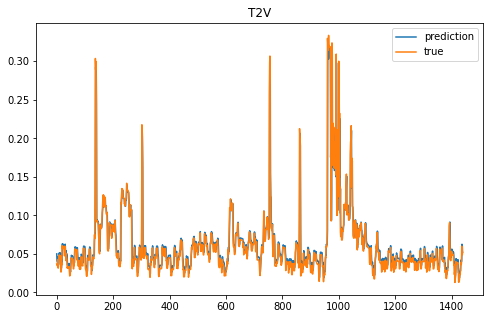

In [78]:
### VISUALIZE TEST PREDICTIONS ON HOUSE 1 ###

plt.figure(figsize=(8,5))

plt.plot(y_pred_h1.ravel()[:24*60], label='prediction')
plt.plot(y_test_h1.ravel()[:24*60], label='true')
plt.title('T2V');
plt.legend();

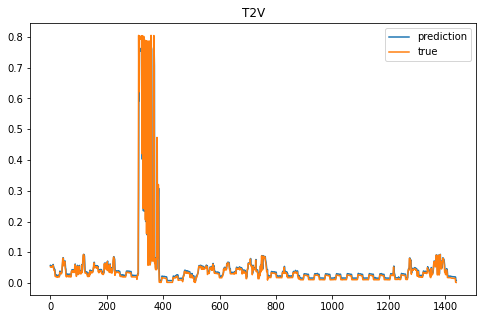

In [79]:
### VISUALIZE TEST PREDICTIONS ON HOUSE 2 ###

plt.figure(figsize=(8,5))

plt.plot(y_pred_h2.ravel()[:24*60], label='prediction')
plt.plot(y_test_h2.ravel()[:24*60], label='true')
plt.title('T2V');
plt.legend();

Now that our Time2Vec model is trained, we can use its embedding as a first layer of neural network for a binary classification task.

# 2. Using our embeddings for classification

In [127]:
X_h2, Y_h2 = [], []
for sequence in gen_sequence(house2_power_blk1, sequence_length, ['mains']):
    X_h2.append(sequence)
    
for sequence in gen_labels(house2_power_blk1, sequence_length, ['activity']):
    Y_h2.append(sequence)
    
X_h2 = np.asarray(X_h2)
Y_h2 = np.asarray(Y_h2)

In [128]:
### TRAIN TEST SPLIT ###

train_dim_h2 = int(0.7*len(house2_power_blk1))
X_train_h2, X_test_h2 = X_h2[:train_dim_h2], X_h2[train_dim_h2:]
y_train_h2, y_test_h2 = Y_h2[:train_dim_h2], Y_h2[train_dim_h2:]

print(X_train_h2.shape, y_train_h2.shape)
print(X_test_h2.shape, y_test_h2.shape)

(59513, 60, 1) (59513, 1)
(25447, 60, 1) (25447, 1)


In [129]:
X_h1, Y_h1 = [], []
for sequence in gen_sequence(house1_power_blk2, sequence_length, ['mains']):
    X_h1.append(sequence)
    
for sequence in gen_labels(house1_power_blk2, sequence_length, ['activity']):
    Y_h1.append(sequence)
    
X_h1 = np.asarray(X_h1)
Y_h1 = np.asarray(Y_h1)

In [130]:
### TRAIN TEST SPLIT ###

train_dim_h1 = int(0.7*len(house1_power_blk2))
X_train_h1, X_test_h1 = X_h1[:train_dim_h1], X_h1[train_dim_h1:]
y_train_h1, y_test_h1 = Y_h1[:train_dim_h1], Y_h1[train_dim_h1:]

print(X_train_h1.shape, y_train_h1.shape)
print(X_test_h1.shape, y_test_h1.shape)

(63461, 60, 1) (63461, 1)
(27139, 60, 1) (27139, 1)


In [131]:
### RE-DEFINE T2V LAYER ###

class T2V(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(input_shape[-1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(input_shape[1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        self.p = self.add_weight(name='p',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        super(T2V, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        
        return K.concatenate([sin_trans, original], -1)

In [137]:
### DEFINE CLASSIFICATION MODEL STRUCTURES ###

def T2V_NN_C(param, dim):
    
    # set_seed(33)
    
    inp = Input(shape=(dim,1))
    #x = Dropout(0.2)(inp)
    # we take the last timestep
    x = T2V(param['t2v_dim'])(inp)[:,-1]
    x = Dropout(0.1)(x)

    # we take the last timestep
    #x = Lambda(lambda x: x[:,-1])(x)

    # we want to make a classification with 2 classes
    x = Dense(1, activation='sigmoid')(x)
    
    m = Model(inp, x)
    m.compile(loss='bce', optimizer='adam') #Adam(learning_rate=param['lr'])
    
    return m

In [138]:
### LOAD OUR WEIGHTS ###
#t2v_weights = pickle.load(open('t2v_weights_norm_house1.pkl', 'rb'))


early_stop = EarlyStopping(patience=5, verbose=0, min_delta=0.0001, monitor='loss', mode='auto', restore_best_weights=True)
best_params = {'unit': 32, 't2v_dim': 128, 'epochs': 20, 'batch_size': 1024}
kgs_t2v_c = T2V_NN_C(param=best_params, dim=sequence_length)

kgs_t2v_c.layers[1].set_weights(t2v_weights)

# to ensable fine-tuning
kgs_t2v_c.layers[1].trainable = True

kgs_t2v_c.summary();

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 60, 1)]           0         
                                                                 
 t2v_18 (T2V)                (None, 60, 129)           7928      
                                                                 
 tf.__operators__.getitem_16  (None, 129)              0         
  (SlicingOpLambda)                                              
                                                                 
 dropout_22 (Dropout)        (None, 129)               0         
                                                                 
 dense_17 (Dense)            (None, 1)                 130       
                                                                 
Total params: 8,058
Trainable params: 8,058
Non-trainable params: 0
________________________________________________________

Let's train our model on house 1.

In [139]:
kgs_t2v_c.fit(X_train_h1, y_train_h1, epochs=best_params['epochs'], batch_size=best_params['batch_size'], callbacks=[early_stop]);

Epoch 1/20
62/62 [==============================] - 1s 5ms/step - loss: 0.6816
Epoch 2/20
62/62 [==============================] - 0s 5ms/step - loss: 0.6589
Epoch 3/20
62/62 [==============================] - 0s 5ms/step - loss: 0.6394
Epoch 4/20
62/62 [==============================] - 0s 5ms/step - loss: 0.6294
Epoch 5/20
62/62 [==============================] - 0s 5ms/step - loss: 0.6268
Epoch 6/20
62/62 [==============================] - 0s 5ms/step - loss: 0.6265
Epoch 7/20
62/62 [==============================] - 0s 5ms/step - loss: 0.6264
Epoch 8/20
62/62 [==============================] - 0s 5ms/step - loss: 0.6265
Epoch 9/20
62/62 [==============================] - 0s 5ms/step - loss: 0.6263
Epoch 10/20
62/62 [==============================] - 0s 5ms/step - loss: 0.6263
Epoch 11/20
62/62 [==============================] - 0s 5ms/step - loss: 0.6262
Epoch 12/20
62/62 [==============================] - 0s 5ms/step - loss: 0.6263
Epoch 13/20
62/62 [==============================

We can now make predictions and have a look at the performances. The model has been trained on house 1 so first let's have a look at the score on the test dataset from house 1.

Score f_beta : 62.030%
Score accuracy : 64.730%


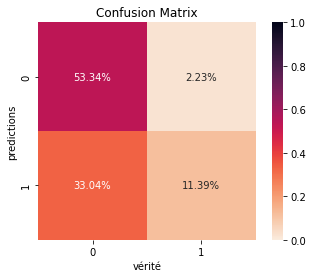

In [140]:
y_pred_h1 = kgs_t2v_c.predict(X_test_h1)
mod.plot_confusion_matrix(y_test_h1.ravel(), (y_pred_h1.ravel()>0.5).astype(int));

Now let's have a look at the score on the test dataset from house 2.

Score f_beta : 49.827%
Score accuracy : 60.663%


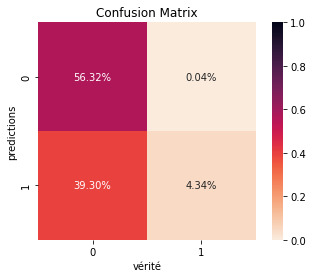

In [141]:
y_pred_h2 = kgs_t2v_c.predict(X_test_h2)
mod.plot_confusion_matrix(y_test_h2.ravel(), (y_pred_h2.ravel()>0.5).astype(int));

Now let's train our model on house 2.

In [36]:
kgs_t2v_c.fit(X_train_h2, y_train_h2, epochs=best_params['epochs'], batch_size=best_params['batch_size'], callbacks=[early_stop]);

Epoch 1/20
59/59 [==============================] - 1s 4ms/step - loss: 0.6796
Epoch 2/20
59/59 [==============================] - 0s 4ms/step - loss: 0.6631
Epoch 3/20
59/59 [==============================] - 0s 4ms/step - loss: 0.6423
Epoch 4/20
59/59 [==============================] - 0s 4ms/step - loss: 0.6175
Epoch 5/20
59/59 [==============================] - 0s 4ms/step - loss: 0.5899
Epoch 6/20
59/59 [==============================] - 0s 4ms/step - loss: 0.5624
Epoch 7/20
59/59 [==============================] - 0s 4ms/step - loss: 0.5368
Epoch 8/20
59/59 [==============================] - 0s 4ms/step - loss: 0.5152
Epoch 9/20
59/59 [==============================] - 0s 4ms/step - loss: 0.4977
Epoch 10/20
59/59 [==============================] - 0s 4ms/step - loss: 0.4842
Epoch 11/20
59/59 [==============================] - 0s 4ms/step - loss: 0.4746
Epoch 12/20
59/59 [==============================] - 0s 4ms/step - loss: 0.4673
Epoch 13/20
59/59 [==============================

We can now make predictions and have a look at the performances. Let's have a look at the score on the test dataset from house 1.

Score f_beta : 48.613%
Score accuracy : 51.291%


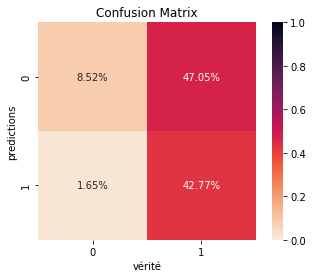

In [37]:
y_pred_h1 = kgs_t2v_c.predict(X_test_h1)
mod.plot_confusion_matrix(y_test_h1.ravel(), (y_pred_h1.ravel()>0.5).astype(int));

Now let's have a look at the score on the test dataset from house 2.

Score f_beta : 78.755%
Score accuracy : 79.062%


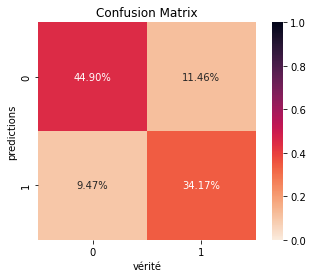

In [38]:
y_pred_h2 = kgs_t2v_c.predict(X_test_h2)
mod.plot_confusion_matrix(y_test_h2.ravel(), (y_pred_h2.ravel()>0.5).astype(int));

Finally we can try to plot our predictions.

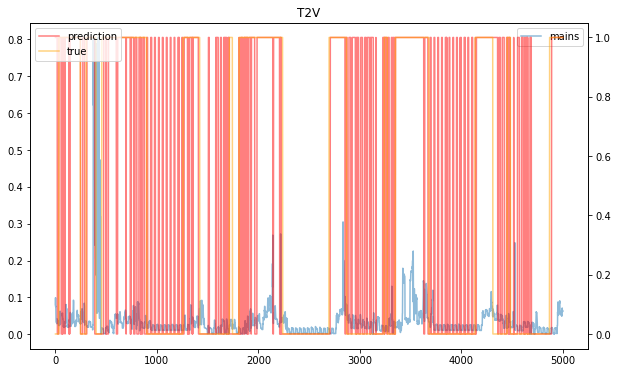

In [39]:
### VISUALIZE TEST PREDICTIONS ON HOUSE 2 ###

fig, ax = plt.subplots(1,1 , figsize=(10,6))
axs = ax.twinx()

ax.plot(X_test_h2[:5000,0], label='mains', alpha=0.5)
axs.plot(y_pred_h2[:5000,0]>0.5, label='prediction', color='red', alpha=0.5)
axs.plot(y_test_h2[:5000,0], label='true', color='orange', alpha=0.5)
plt.title('T2V');
ax.legend(loc='upper right');
axs.legend(loc='upper left');

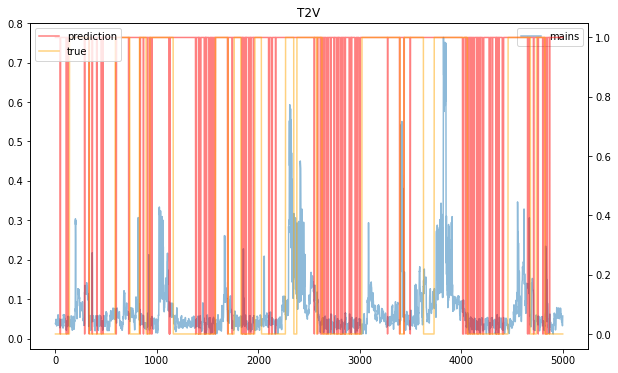

In [40]:
### VISUALIZE TEST PREDICTIONS ON HOUSE 1 ###

fig, ax = plt.subplots(1,1 , figsize=(10,6))
axs = ax.twinx()

ax.plot(X_test_h1[:5000,0], label='mains', alpha=0.5)
axs.plot((y_pred_h1[:5000,0]>0.5), label='prediction', color='red', alpha=0.5)
axs.plot(y_test_h1[:5000,0], label='true', color='orange', alpha=0.5)
plt.title('T2V');
ax.legend(loc='upper right');
axs.legend(loc='upper left');

Looking at the plots, it looks like our model sucessfully identifies the period of times with a lot of variation on the load curve.

In [41]:
house1_power_blk2_res = house1_power_blk2.copy()
house1_power_blk2_res['activity_pred'] = np.nan
house1_power_blk2_res['activity_pred'].iloc[train_dim_h1:-60] = (y_pred_h1[:, 0].reshape(-1) > 0.5).astype(int)
house1_power_blk2_res.iloc[train_dim_h1:-60].head()

/home/pierre/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,mains,activity,hour,activity_pred
datetime,,,,
2016-04-19 01:41:00,0.038257,0,1.683333,1.0
2016-04-19 01:42:00,0.036625,0,1.700000,1.0
2016-04-19 01:43:00,0.037153,0,1.716667,1.0
2016-04-19 01:44:00,0.038520,0,1.733333,1.0
2016-04-19 01:45:00,0.045619,0,1.750000,1.0


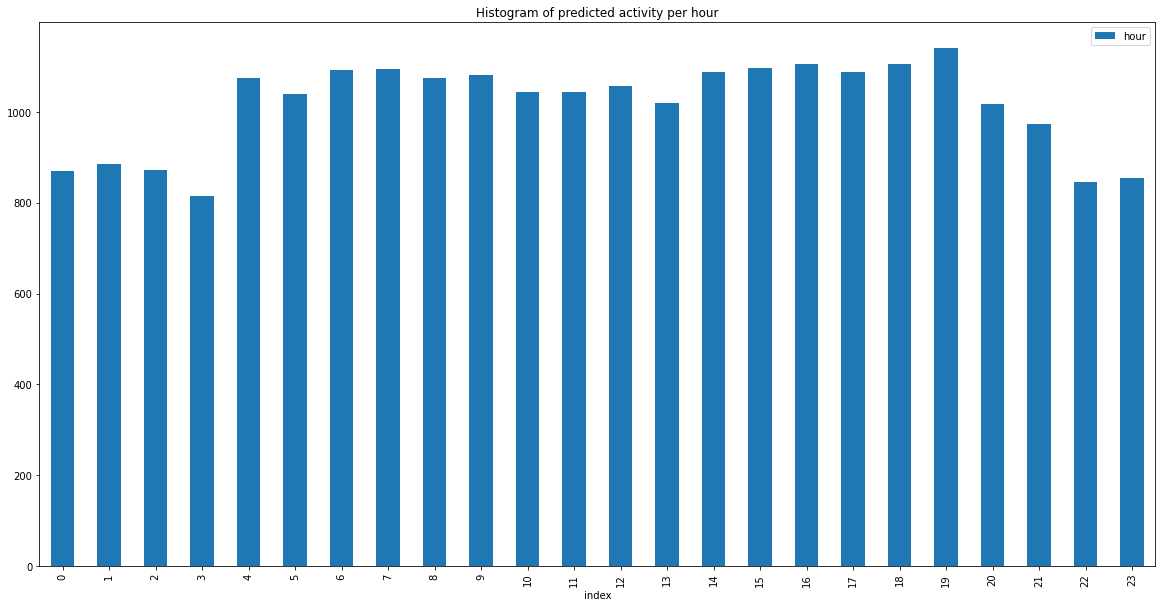

In [42]:
pd.DataFrame(house1_power_blk2_res.loc[house1_power_blk2_res['activity_pred'] > 0, 'hour'].astype(int).value_counts()).reset_index(drop=False).sort_values(by='index').plot.bar(x='index', y='hour', figsize=(20,10), legend='Histogramme activité=f(heure)', title='Histogram of predicted activity per hour');

In [43]:
house2_power_blk1_res = house2_power_blk1.copy()
house2_power_blk1_res['activity_pred'] = np.nan
house2_power_blk1_res['activity_pred'].iloc[train_dim_h2:-60] = (y_pred_h2[:, 0].reshape(-1) > 0.5).astype(int)
house2_power_blk1_res.iloc[train_dim_h2:-60].head()

/home/pierre/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,mains,activity,hour,activity_pred
datetime,,,,
2017-10-24 06:53:00,0.079947,1,6.883333,1.0
2017-10-24 06:54:00,0.099201,1,6.900000,1.0
2017-10-24 06:55:00,0.074445,1,6.916667,1.0
2017-10-24 06:56:00,0.076376,1,6.933333,1.0
2017-10-24 06:57:00,0.075961,1,6.950000,1.0


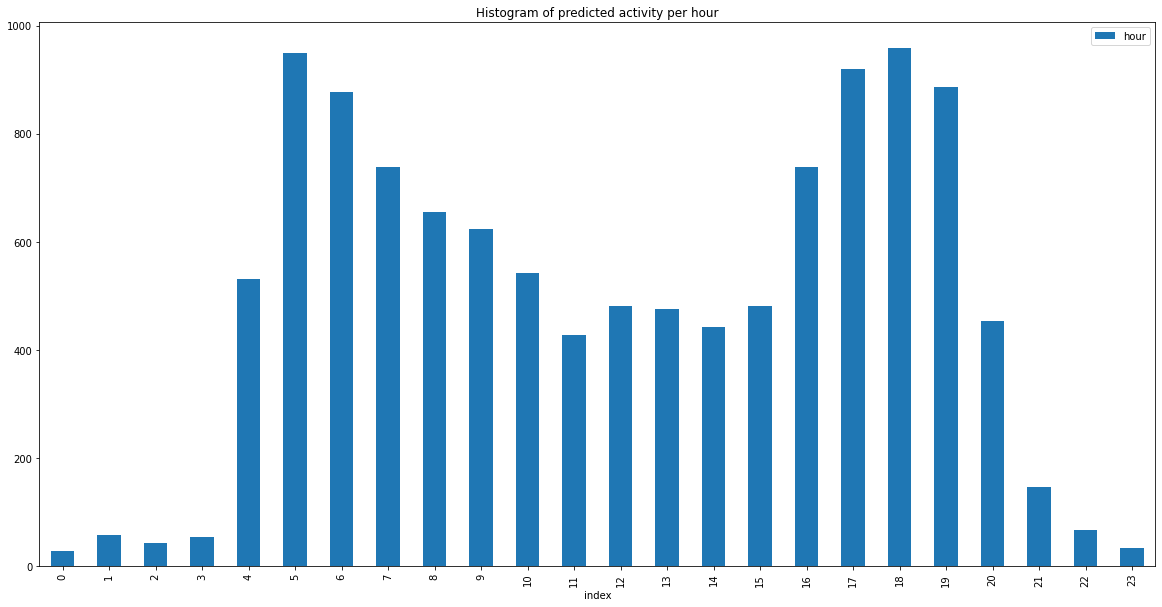

In [44]:
pd.DataFrame(house2_power_blk1_res.loc[house2_power_blk1_res['activity_pred'] > 0, 'hour'].astype(int).value_counts()).reset_index(drop=False).sort_values(by='index').plot.bar(x='index', y='hour', figsize=(20,10), legend='Histogramme activité=f(heure)', title='Histogram of predicted activity per hour');